# Notebook 2 — KMeans (k=5) com **todas as features** e comparação

- Texto: sinopse (TF‑IDF)
- Numéricas: rating, votes, year, runtime_minutes
- Categóricas multilabel: genres (binarizada)

Comparamos **Modelo 1 (só sinopse)** vs **Modelo 2 (todas as features)** usando métricas e interpretação.


In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt

DATA_DIR = Path('data')
raw_path = DATA_DIR / 'imdb_top250_raw.csv'
df = pd.read_csv(raw_path)

# Limpezas
for col in ['title','synopsis','genres','certificate','directors','stars']:
    if col in df.columns:
        df[col] = df[col].fillna('')

def ensure_int(x):
    try: return int(x)
    except: return np.nan

def ensure_float(x):
    try: return float(x)
    except: return np.nan

df['year'] = df['year'].apply(ensure_int)
df['runtime_minutes'] = df['runtime_minutes'].apply(ensure_int)
df['rating'] = df['rating'].apply(ensure_float)
df['votes'] = df['votes'].apply(ensure_int)

df['genres_list'] = df['genres'].apply(lambda s: [g.strip() for g in str(s).split('|') if g.strip()])


In [3]:
# Texto (TF-IDF)
text_vec = TfidfVectorizer(
    stop_words='english',
    max_features=25000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)
X_text = text_vec.fit_transform(df['synopsis'])

# Gêneros -> binário
all_genres = sorted({g for lst in df['genres_list'] for g in lst})
genre_mat = np.zeros((len(df), len(all_genres)), dtype=np.float32)
idx_map = {g:i for i,g in enumerate(all_genres)}
for row_i, lst in enumerate(df['genres_list']):
    for g in lst:
        j = idx_map[g]
        genre_mat[row_i, j] = 1.0
X_genres = csr_matrix(genre_mat)

# Numéricas
num_cols = ['rating','votes','year','runtime_minutes']
X_num = df[num_cols].copy()
for c in num_cols: X_num[c] = X_num[c].fillna(X_num[c].median())
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num.values)
X_num_sparse = csr_matrix(X_num_scaled)

# Combina
X_all = hstack([X_text, X_genres, X_num_sparse], format='csr')
print('Dimensões:')
print('X_text ', X_text.shape)
print('X_genres ', X_genres.shape)
print('X_num ', X_num_sparse.shape)
print('X_all ', X_all.shape)


Dimensões:
X_text  (25, 35)
X_genres  (25, 0)
X_num  (25, 4)
X_all  (25, 39)


C:\Users\thi18\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\thi18\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\thi18\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\thi18\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [12]:
# MODELO 1: apenas sinopse
MBK = MiniBatchKMeans(n_clusters=5, random_state=42, n_init=20, batch_size=64)
labels_m1 = MBK.fit_predict(X_text)

# Ajuste automático do n_components do SVD
n_feats = X_text.shape[1]
n_comp = max(2, min(50, n_feats - 1))  # precisa ser < n_feats e pelo menos 2

svd1 = TruncatedSVD(n_components=n_comp, random_state=42)
X1_red = svd1.fit_transform(X_text)

m1_sil = silhouette_score(X1_red, labels_m1)
m1_cal = calinski_harabasz_score(X1_red, labels_m1)
m1_dav = davies_bouldin_score(X1_red, labels_m1)

print('\nMétricas — Modelo 1 (só sinopse)')
print(f'Silhouette: {m1_sil:.4f} (maior é melhor)')
print(f'Calinski-Harabasz: {m1_cal:.2f} (maior é melhor)')
print(f'Davies-Bouldin: {m1_dav:.4f} (menor é melhor)')


Métricas — Modelo 1 (só sinopse)
Silhouette: 0.1169 (maior é melhor)
Calinski-Harabasz: 1.83 (maior é melhor)
Davies-Bouldin: 1.0913 (menor é melhor)


In [13]:
# -----------------------------
# Numéricas (corrigido para evitar NaN)
# -----------------------------
num_cols = ['rating','votes','year','runtime_minutes']

# Preenche NaN com mediana; se a coluna for toda NaN, usa 0 como fallback
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
    if df[c].isna().any():
        df[c] = df[c].fillna(0)

X_num = df[num_cols].copy()

# Escala (z-score)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num.values)

# Verificação explícita de NaN
import numpy as np
print("Tem NaN em X_num_scaled?", np.isnan(X_num_scaled).any())

X_num_sparse = csr_matrix(X_num_scaled)

# -----------------------------
# Texto e gêneros (garantia de não ter NaN)
# -----------------------------
df['synopsis'] = df['synopsis'].fillna('')
df['genres'] = df['genres'].fillna('')
df['genres_list'] = df['genres'].apply(lambda s: [g.strip() for g in str(s).split('|') if g.strip()])

# -----------------------------
# Combina todas as features
# -----------------------------
X_all = hstack([X_text, X_genres, X_num_sparse], format='csr')

print("Shape final de X_all:", X_all.shape)# -----------------------------
# Numéricas (corrigido para evitar NaN)
# -----------------------------
num_cols = ['rating','votes','year','runtime_minutes']

# Preenche NaN com mediana; se a coluna for toda NaN, usa 0 como fallback
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
    if df[c].isna().any():
        df[c] = df[c].fillna(0)

X_num = df[num_cols].copy()

# Escala (z-score)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num.values)

# Verificação explícita de NaN
import numpy as np
print("Tem NaN em X_num_scaled?", np.isnan(X_num_scaled).any())

X_num_sparse = csr_matrix(X_num_scaled)

# -----------------------------
# Texto e gêneros (garantia de não ter NaN)
# -----------------------------
df['synopsis'] = df['synopsis'].fillna('')
df['genres'] = df['genres'].fillna('')
df['genres_list'] = df['genres'].apply(lambda s: [g.strip() for g in str(s).split('|') if g.strip()])

# -----------------------------
# Combina todas as features
# -----------------------------
X_all = hstack([X_text, X_genres, X_num_sparse], format='csr')

print("Shape final de X_all:", X_all.shape)

C:\Users\thi18\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Tem NaN em X_num_scaled? False
Shape final de X_all: (25, 39)
Tem NaN em X_num_scaled? False
Shape final de X_all: (25, 39)


In [14]:
# MODELO 2: todas as features
# -----------------------------
MBK = MiniBatchKMeans(n_clusters=5, random_state=42, n_init=20, batch_size=64)
labels_m2 = MBK.fit_predict(X_all)

# Ajuste automático do n_components do SVD
n_feats_all = X_all.shape[1]
n_comp_all = max(2, min(50, n_feats_all - 1))  # precisa ser < n_feats_all e >= 2

svd2 = TruncatedSVD(n_components=n_comp_all, random_state=42)
X2_red = svd2.fit_transform(X_all)

m2_sil = silhouette_score(X2_red, labels_m2)
m2_cal = calinski_harabasz_score(X2_red, labels_m2)
m2_dav = davies_bouldin_score(X2_red, labels_m2)

print('\nMétricas — Modelo 2 (todas as features)')
print(f'Silhouette: {m2_sil:.4f} (maior é melhor)')
print(f'Calinski-Harabasz: {m2_cal:.2f} (maior é melhor)')
print(f'Davies-Bouldin: {m2_dav:.4f} (menor é melhor)')



Métricas — Modelo 2 (todas as features)
Silhouette: 0.1239 (maior é melhor)
Calinski-Harabasz: 5.12 (maior é melhor)
Davies-Bouldin: 1.1876 (menor é melhor)


In [15]:
# Comparação e saída
comp = pd.DataFrame({
    'modelo': ['sinopse','todas_features'],
    'silhouette (↑)': [m1_sil, m2_sil],
    'calinski_harabasz (↑)': [m1_cal, m2_cal],
    'davies_bouldin (↓)': [m1_dav, m2_dav],
})
comp


,modelo,silhouette (↑),calinski_harabasz (↑),davies_bouldin (↓)
0,sinopse,0.116927,1.832941,1.091309
1,todas_features,0.123938,5.119363,1.187646


In [16]:
# Heurística simples de escolha
score_m1 = (m1_sil*1.0) + (m1_cal/10000.0) - (m1_dav*0.5)
score_m2 = (m2_sil*1.0) + (m2_cal/10000.0) - (m2_dav*0.5)
melhor = 'Modelo 1 (só sinopse)' if score_m1 > score_m2 else 'Modelo 2 (todas features)'
print(f">>> Melhor opção (heurística): {melhor}")


>>> Melhor opção (heurística): Modelo 1 (só sinopse)


In [17]:
# Salva rótulos
out1 = df.copy(); out1['cluster_k5_m1'] = labels_m1
out2 = df.copy(); out2['cluster_k5_m2'] = labels_m2

out1_path = Path('data') / 'imdb_top250_k5_synopsis.csv'
out2_path = Path('data') / 'imdb_top250_k5_allfeatures.csv'

out1.to_csv(out1_path, index=False, encoding='utf-8-sig')
out2.to_csv(out2_path, index=False, encoding='utf-8-sig')
print(f"Salvo: {out1_path.resolve()}")
print(f"Salvo: {out2_path.resolve()}")


Salvo: C:\Users\thi18\Downloads\projeto-imdb-recommender\notebooks\data\imdb_top250_k5_synopsis.csv
Salvo: C:\Users\thi18\Downloads\projeto-imdb-recommender\notebooks\data\imdb_top250_k5_allfeatures.csv


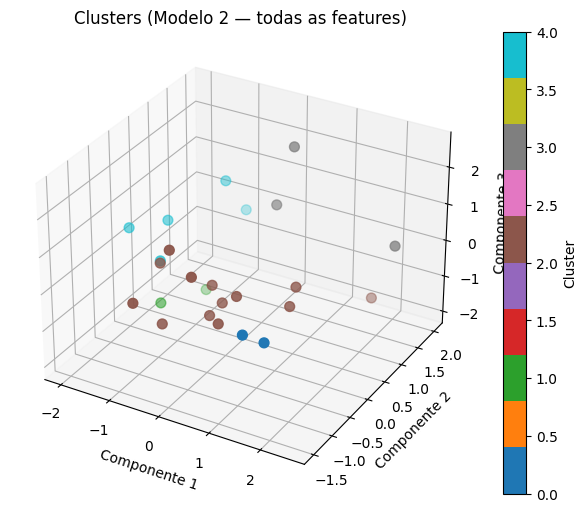

In [18]:
# Visual simples: tamanho dos clusters (Modelo 2)
svd2 = TruncatedSVD(n_components=3, random_state=42)
X2_red_3d = svd2.fit_transform(X_all)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X2_red_3d[:,0], X2_red_3d[:,1], X2_red_3d[:,2], 
                c=labels_m2, cmap='tab10', s=50)

ax.set_title("Clusters (Modelo 2 — todas as features)", fontsize=12)
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.colorbar(sc, ax=ax, label="Cluster")
plt.show()

### Conclusão (preencha)
- Compare métricas e interpretabilidade dos clusters.
- Escolha do melhor modelo e **justificativa**.
- Limitações: HTML do IMDB pode mudar, idioma, silhouette com redução, etc.
